In [1]:

import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:

ck_data = h5py.File('./CK_data.h5', 'r', driver='core')
X_data = np.expand_dims(np.asarray(ck_data['data_pixel']), axis=-1)
X_data = X_data.reshape((981,48*48))
y_data = np.asarray(ck_data['data_label'])
y_data = to_categorical(y_data)
n_classes = y_data.shape[1]

In [3]:
print(ck_data)
print(X_data)

<HDF5 file "CK_data.h5" (mode r)>
[[ 24  10  13 ... 150 153 156]
 [ 17  10  16 ... 151 153 156]
 [ 27  13  10 ... 148 152 156]
 ...
 [196 142 167 ...  59  56  42]
 [196 143 168 ...  59  56  41]
 [198 125 179 ...  59  54  40]]


In [4]:
print(y_data)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [5]:
print(n_classes)

7


In [6]:
print(y_data.shape[0])

981


In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.3,random_state=0)

In [8]:
print('Training: ',X_train.shape)
print('Validation: ',X_validation.shape)

Training:  (686, 2304)
Validation:  (295, 2304)


In [9]:
n_components = 10
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_validation)

In [10]:
print(X_train_pca)

[[ 2.63805157 -0.70786935  0.08723131 ... -0.16757715 -0.52433086
  -0.17216354]
 [ 1.15436173 -0.62759823 -0.5049575  ... -0.35809285 -1.06118513
   0.1547224 ]
 [-1.01615348  2.0080951  -1.47292256 ... -0.52612428  1.14131426
  -1.08358111]
 ...
 [ 0.16847624  0.69031498  0.41216178 ... -1.53263806 -0.3084822
  -0.18823507]
 [ 0.73039312 -1.0996472   0.42111927 ... -0.44859442 -0.02663744
   0.89848255]
 [ 1.40953959  0.09495162  2.10538588 ...  1.95950123  0.71771083
   0.08135759]]


In [11]:
print(X_val_pca)

[[-0.87293696 -1.53689979  1.24549942 ...  0.74430914 -0.68646081
  -0.12040035]
 [-1.92069894  1.40614179  0.0938059  ... -1.13162814 -0.46218718
   0.07623163]
 [-1.53142684  1.35692776 -0.46550434 ... -0.70693924 -0.83893406
   0.87352858]
 ...
 [ 1.73584517 -0.08005549 -1.46719629 ... -0.72505394 -1.37520926
  -0.37041943]
 [-0.57221586 -0.09020579 -0.88552609 ... -0.94666186  0.91555996
   0.70250082]
 [ 0.42498313 -1.10282857 -1.3394409  ...  0.84634693 -0.1970573
   2.5863515 ]]


In [12]:
print(X_train)

[[  0   0   1 ...  16  18  25]
 [ 60  60  42 ...  57  55  54]
 [ 48  56  71 ... 145 148 152]
 ...
 [ 86  87  87 ...  89  89  88]
 [ 36  38  25 ...   1   3  10]
 [255 255 244 ...  23  19  13]]


In [13]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

In [14]:

def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.05, right=.95, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

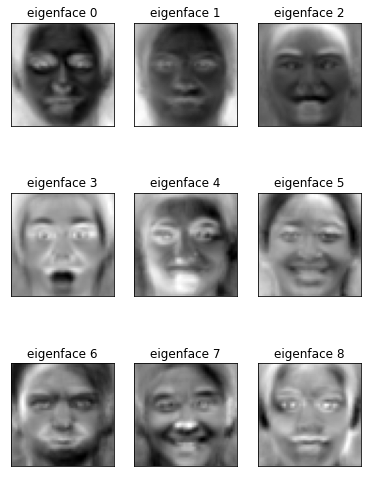

In [15]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 48, 48)

In [16]:

plt.show()
y_train_ = np.argmax(y_train, axis=-1)
y_train_.shape

(686,)

In [17]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.1], }
clf = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train_)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.331s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [18]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_val_pca)
print("done in %0.3fs" % (time() - t0))
y_val = np.argmax(y_validation, axis=-1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.004s
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        33
           1       1.00      0.94      0.97        54
           2       0.95      0.73      0.83        26
           3       0.95      0.98      0.97        62
           4       0.88      1.00      0.94        22
           5       0.97      0.94      0.96        80
           6       0.88      0.83      0.86        18

    accuracy                           0.94       295
   macro avg       0.92      0.92      0.92       295
weighted avg       0.94      0.94      0.94       295

[[33  0  0  0  0  0  0]
 [ 1 51  0  0  0  2  0]
 [ 4  0 19  3  0  0  0]
 [ 0  0  1 61  0  0  0]
 [ 0  0  0  0 22  0  0]
 [ 0  0  0  0  3 75  2]
 [ 3  0  0  0  0  0 15]]


In [19]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train_)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.419s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [20]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_val_pca)
print("done in %0.3fs" % (time() - t0))
y_val = np.argmax(y_validation, axis=-1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.008s
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        33
           1       0.90      0.96      0.93        54
           2       1.00      0.77      0.87        26
           3       0.94      1.00      0.97        62
           4       0.96      1.00      0.98        22
           5       1.00      0.91      0.95        80
           6       1.00      0.83      0.91        18

    accuracy                           0.93       295
   macro avg       0.94      0.92      0.92       295
weighted avg       0.94      0.93      0.93       295

[[31  2  0  0  0  0  0]
 [ 2 52  0  0  0  0  0]
 [ 1  1 20  4  0  0  0]
 [ 0  0  0 62  0  0  0]
 [ 0  0  0  0 22  0  0]
 [ 3  3  0  0  1 73  0]
 [ 3  0  0  0  0  0 15]]
